# this is the online notebook approach

In [1]:
import pandas as pd
import numpy as np
import arviz as az

path = r"/Users/christian/supsi/6th sem/bayesian_retry/retry/points_df.csv"
path2 = r"/Users/christian/supsi/6th sem/bayesian_retry/retry/outcomes.csv"
observed = pd.read_csv(path2, index_col=0)
points_df = pd.read_csv(path, index_col=0)
points_df

,EHC Biel-Bienne (away),HC Lugano (away),ZSC Lions (home),HC Ambri-Piotta (away),SC Bern (home),EV Zug (home),Genève-Servette HC (away),SC Rapperswil-Jona Lakers (home),SCL Tigers (away),HC Davos (home),...,ZSC Lions (away),HC Ambri-Piotta (home),SC Bern (away),EV Zug (away),Genève-Servette HC (home),EHC Biel-Bienne (home),SC Rapperswil-Jona Lakers (away),Lausanne HC (home),HC Ajoie (home),HC Ajoie (away)
HC Ajoie,3.500000,7.000000,6.500000,2.000000,4.000000,6.500000,3.500000,4.666667,1.500000,4.500000,...,3.333333,2.500000,4.000000,4.000000,3.500000,5.5,6.0,3.500000,0.000000,0.000000
SC Bern,3.666667,2.000000,2.000000,3.500000,0.000000,3.500000,2.333333,2.000000,1.000000,3.500000,...,1.000000,3.000000,0.000000,2.500000,2.500000,7.0,2.5,3.666667,1.500000,0.500000
Fribourg-Gottéron,2.000000,2.000000,4.500000,1.500000,1.500000,3.000000,1.333333,4.500000,2.000000,1.000000,...,2.250000,4.000000,2.333333,3.500000,2.500000,2.5,1.5,3.000000,0.500000,2.000000
ZSC Lions,2.500000,3.000000,0.000000,2.000000,4.000000,2.666667,3.500000,3.333333,2.666667,2.500000,...,0.000000,1.000000,2.000000,2.600000,3.000000,1.6,2.0,3.500000,2.666667,2.000000
Genève-Servette HC,1.333333,3.000000,5.500000,6.500000,2.333333,3.000000,0.000000,3.000000,1.500000,2.000000,...,0.500000,1.500000,1.000000,2.000000,0.000000,3.5,0.5,2.500000,3.500000,2.500000
EV Zug,2.500000,1.800000,1.000000,2.000000,3.500000,0.000000,4.500000,4.000000,2.000000,1.250000,...,2.166667,2.333333,1.500000,0.000000,3.500000,3.5,2.5,3.500000,1.500000,1.500000
HC Davos,1.000000,1.000000,3.666667,1.500000,3.000000,4.500000,1.000000,2.500000,4.000000,0.000000,...,3.000000,2.500000,2.000000,1.500000,3.000000,2.5,2.5,2.000000,2.000000,0.000000
HC Lugano,4.000000,0.000000,5.000000,1.333333,2.500000,4.800000,2.333333,1.500000,2.500000,3.000000,...,3.500000,2.000000,1.500000,4.400000,2.333333,4.0,1.5,6.000000,2.500000,1.000000
SC Rapperswil-Jona Lakers,3.500000,3.500000,4.000000,3.000000,3.000000,1.500000,1.500000,0.000000,3.000000,3.166667,...,3.333333,3.000000,2.000000,1.500000,3.000000,2.5,0.0,2.000000,2.500000,1.666667
Lausanne HC,2.000000,6.000000,3.000000,1.750000,2.000000,1.500000,1.000000,6.000000,3.000000,3.500000,...,2.500000,2.333333,1.666667,2.000000,3.000000,2.0,5.0,0.000000,1.500000,2.000000


In [2]:
import pymc3 as pm

mu = points_df.loc[:, ["HC Lugano (home)", "HC Lugano (away)"]].mean().mean()
sample_poisson = pm.Poisson.dist(mu).random(size=1000)
sample_poisson.mean()

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


2.801

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_hist(sample, **kwargs):
    """Plot a histogram of goals.
    
    sample: sequence of values
    """
    sns.histplot(sample, stat='probability', discrete=True, alpha=0.5, **kwargs)

def legend(**kwargs):
    """Make a legend only if there are labels."""
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend(**kwargs)
        
def decorate_goals(ylabel='Probability'):
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel(ylabel)
    plt.title('Distribution of goals scored')
    legend()

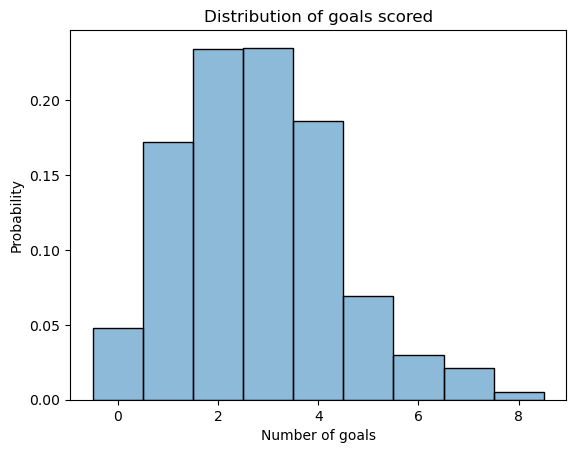

In [4]:
plot_hist(sample_poisson)
decorate_goals()

# The gamma distribution
In the previous section we assume that the goal scoring rate is known, but usually it’s something we have to estimate. If we are not certain what the value of mu is, we can use a distribution to represent possible values and their relative likelihoods.

To represent this distribution, we will use a gamma distribution. That’s not the only option, but the gamma distribution is a reasonable choice because:

* The values in a gamma distribution are continuous and non-negative, so that’s appropriate for representing a goal-scoring rate.

* As we’ll see, the shape of the gamma distribution is consistent with what we know about goal scoring in games like hockey.



We chose the parameters of that distribution, alpha and beta, based on results from previous games.

In [5]:
alpha = 4.6
beta = 1.9

sample_gamma = pm.Gamma.dist(alpha, beta).random(size=1000)

In [6]:
import seaborn as sns

def plot_kde(sample, **kwargs):
    """Plot a distribution using KDE.
    
    sample: sequence of values
    """
    sns.kdeplot(sample, cut=0, **kwargs)

def decorate_rate(ylabel='Likelihood'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    legend()

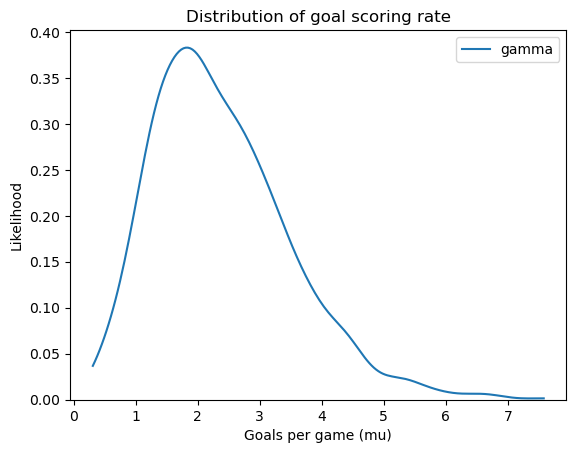

In [7]:
plot_kde(sample_gamma, label='gamma')
decorate_rate()

This distribution represents possible goal-scoring rates for one team against another. When the worst team plays the best team, their goal-scoring rate might be close to 0. When the best team plays the worst, their goal-scoring rate might be 8 goals per game, or more. But for most teams, we expect goal-scoring rates near 2.



# Modelling

In [8]:
with pm.Model() as model1:
    mu = pm.Gamma('mu', alpha, beta)
    trace1 = pm.sample(1000, tune=1000, cores=2, chains=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


In [9]:
sample_prior = az.extract_dataset(trace1.posterior).mu.values
sample_prior.mean()

/var/folders/n3/51xp5_rs54v10cnshxhwyt480000gn/T/ipykernel_42418/516613102.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  sample_prior = az.extract_dataset(trace1.posterior).mu.values


2.395025373422034

the gamma distribution is the prior distribution of mu; that is, it represents our knowledge of goal-scoring rates in general, rather than the goal-scoring rate of one team against another.

In other words, if we don’t know which two teams are playing, this distribution represents what we would believe about mu.

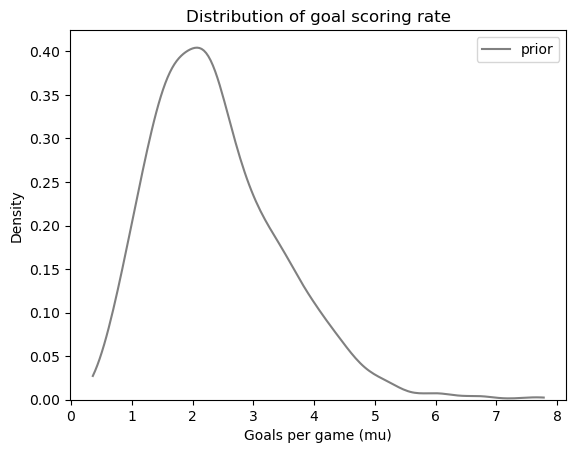

In [10]:
plot_kde(sample_prior, color='gray', label='prior')
decorate_rate('Density')

### Inferencing with a better defined model

For data, let’s whatch what happens when Team HC Lugano plays Team HC Ambri-Piotta and scores a mean of `obs` goals.

In [11]:
# 
obs = points_df.loc["HC Ambri-Piotta", ["HC Lugano (away)", "HC Lugano (home)"]].values

In [12]:
obs.mean()

3.166666666666667

In [13]:
with pm.Model() as model2:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=obs)
    trace2 = pm.sample(1000, tune=1000, cores=2, chains=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


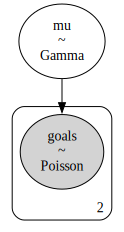

In [14]:
pm.model_to_graphviz(model2)

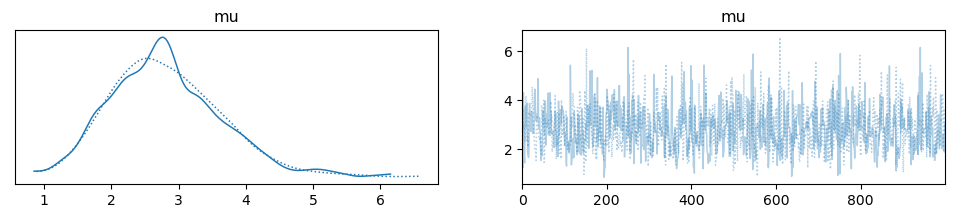

In [15]:
with model2:
    az.plot_trace(trace2)

In [16]:
sample_posterior = az.extract_dataset(trace2.posterior).mu.values

/var/folders/n3/51xp5_rs54v10cnshxhwyt480000gn/T/ipykernel_42418/2648945173.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  sample_posterior = az.extract_dataset(trace2.posterior).mu.values


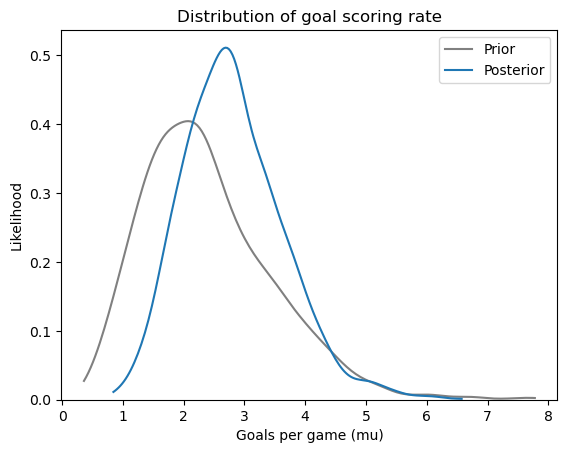

In [17]:
plot_kde(sample_prior, label='Prior', color='gray')
plot_kde(sample_posterior, label='Posterior')
decorate_rate()

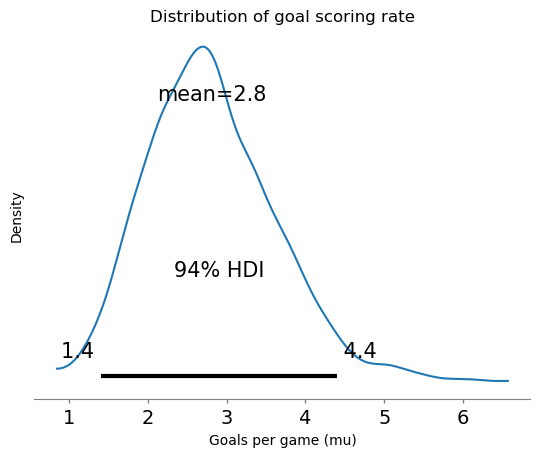

In [18]:
az.plot_posterior(sample_posterior)
decorate_rate('Density')

The 94% HDI is a credible interval that covers 94% of the posterior distribution. Based on the outcome of a single game, there is a 94% chance that the actual goal-scoring rate falls in this range (at least under the assumptions of the model).

# Posterior predictive

This tells us what we should believe about `mu` after we see the data, but it doesn’t tell us how many goals we should expect in the future.

In [19]:
with model2:
    post_pred = pm.sample_posterior_predictive(trace2)

In [20]:
sample_post_pred = post_pred['goals'].flatten()
sample_post_pred.mean()

2.78475

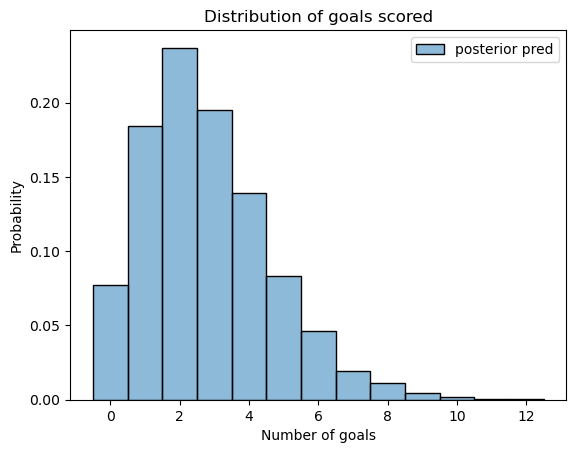

In [21]:
plot_hist(sample_post_pred, label='posterior pred')
decorate_goals()

### with 2 teams

In [22]:
with pm.Model() as model3:
    mu_HCL = pm.Gamma('mu_HCL', alpha, beta)
    mu_HCAP = pm.Gamma('mu_HCAP', alpha, beta)
    goals_HCL = pm.Poisson('goals_HCL', mu_HCL, observed=points_df.loc["HC Ambri-Piotta", ["HC Lugano (away)", "HC Lugano (home)"]].values)
    goals_HCAP = pm.Poisson('goals_HCAP', mu_HCAP, observed=points_df.loc["HC Lugano", ["HC Ambri-Piotta (away)", "HC Ambri-Piotta (home)"]].values)
    trace3 = pm.sample(500)

/var/folders/n3/51xp5_rs54v10cnshxhwyt480000gn/T/ipykernel_42418/2490797101.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace3 = pm.sample(500)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_HCAP, mu_HCL]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 7 seconds.


the results:

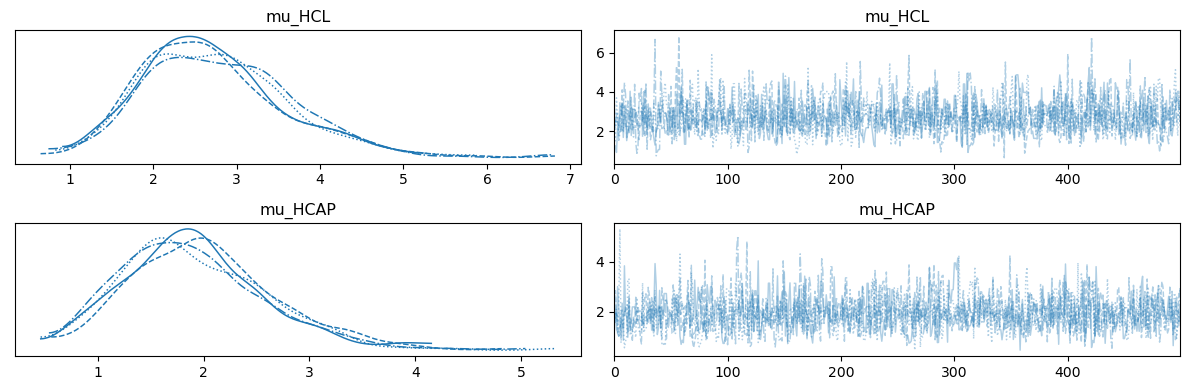

In [23]:
with model3:
    az.plot_trace(trace3)
    plt.tight_layout()

In [25]:
mu_HCL = trace3['mu_HCL']
mu_HCAP = trace3['mu_HCAP']
mu_HCAP.mean(), mu_HCL.mean()

(1.9334030411947707, 2.738907494177706)

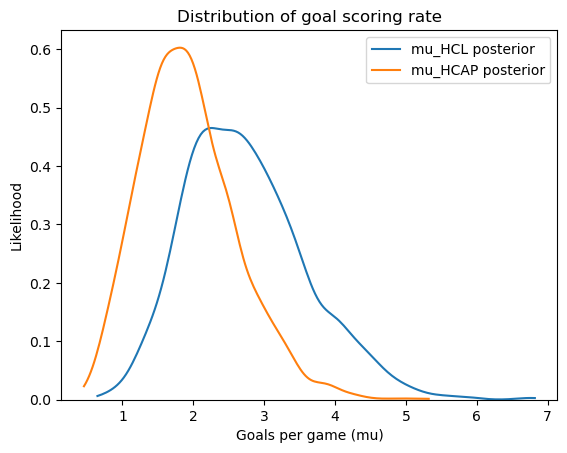

In [26]:
plot_kde(mu_HCL, label='mu_HCL posterior')
plot_kde(mu_HCAP, label='mu_HCAP posterior')
decorate_rate()

In [27]:
(mu_HCL > mu_HCAP).mean()

0.765

Based on the results, we can be fairly confident that HC Lugano is the better team, but that doesn’t necessarily mean they will win the next game.

# Hierarchical

In [ ]:
with pm.Model() as model5:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    trace5 = pm.sample_prior_predictive(1000)

/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/pymc3/distributions/transforms.py:221: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


In [ ]:
sample_prior_mu = trace5['mu']
sample_prior_mu.mean()

6.516758928304112

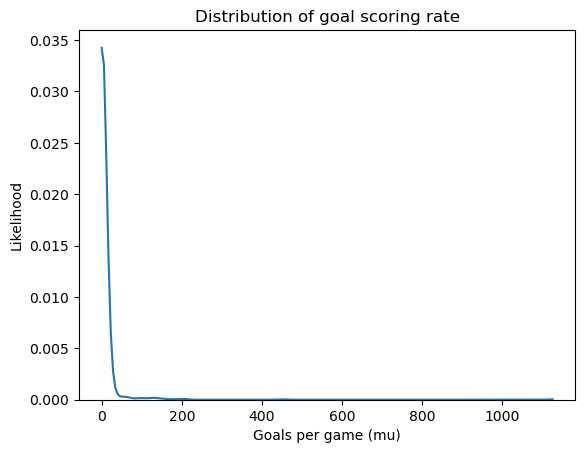

In [ ]:
plot_kde(sample_prior_mu)
decorate_rate()

# with two teams

In [ ]:
with pm.Model() as model6:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu_HCL = pm.Gamma('mu_HCL', alpha, beta)
    mu_HCAP = pm.Gamma('mu_HCAP', alpha, beta)
    goals_HCL = pm.Poisson('goals_HCL', mu_HCL, observed=points_df.loc["HC Ambri-Piotta", ["HC Lugano (away)", "HC Lugano (home)"]].values)
    goals_HCAP = pm.Poisson('goals_HCAP', mu_HCAP, observed=points_df.loc["HC Lugano", ["HC Ambri-Piotta (away)", "HC Ambri-Piotta (home)"]].values)

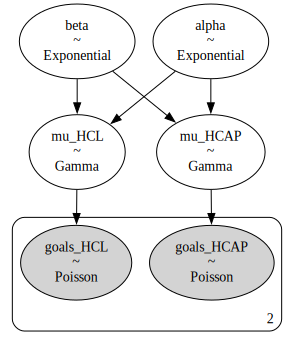

In [ ]:
pm.model_to_graphviz(model6)

In [ ]:
with model6:
    trace6 = pm.sample(500)

/var/folders/n3/51xp5_rs54v10cnshxhwyt480000gn/T/ipykernel_41116/3994245812.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace6 = pm.sample(500)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_HCAP, mu_HCL, beta, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 8 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


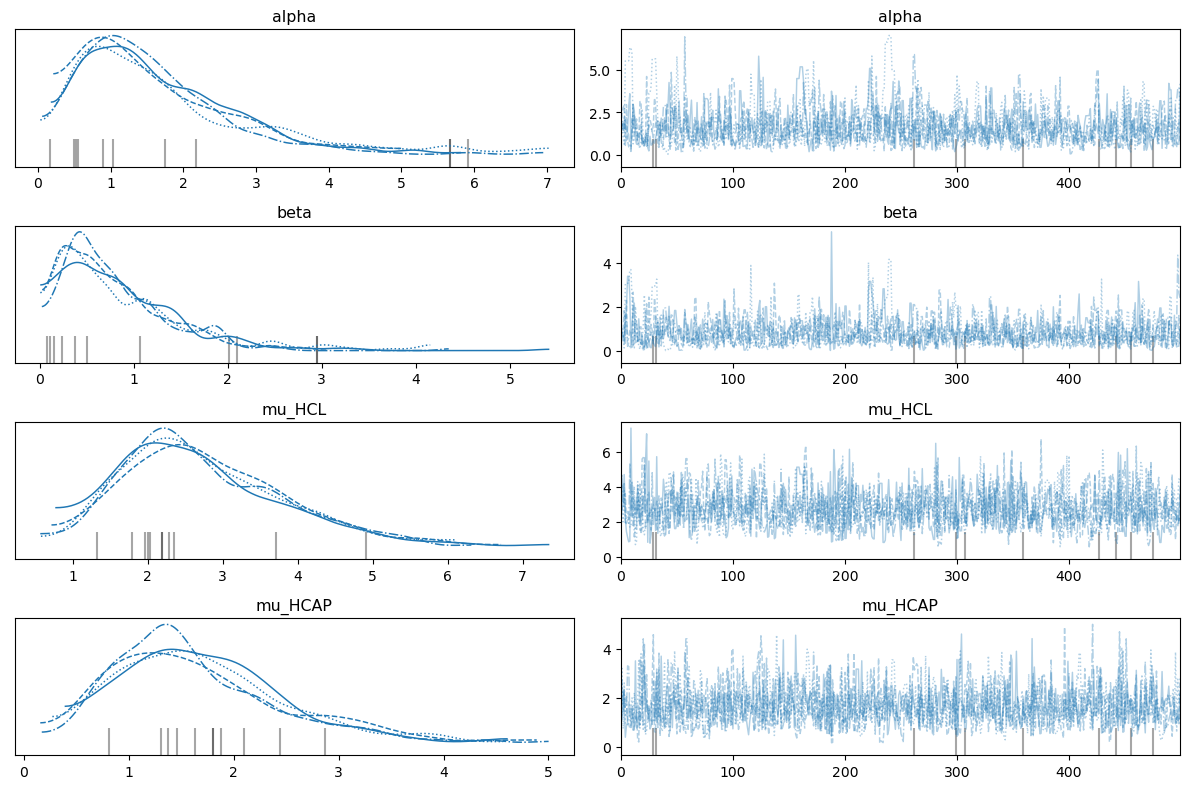

In [ ]:
with model6:
    az.plot_trace(trace6)
    plt.tight_layout()

In [ ]:
mu_HCL = trace6['mu_HCL']
mu_HCAP = trace6['mu_HCAP']
mu_HCAP.mean(), mu_HCL.mean()

(1.6662711038782867, 2.7365367559383773)

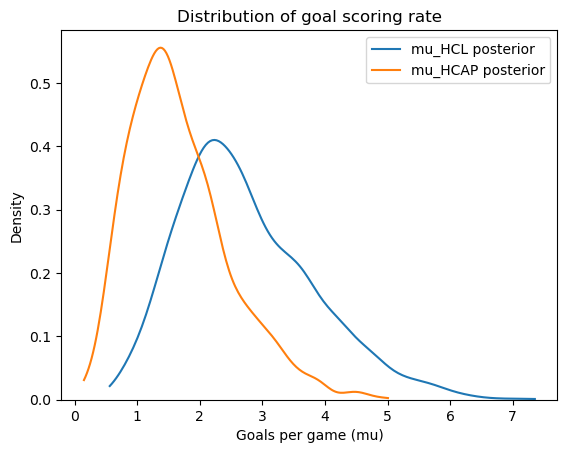

In [ ]:
plot_kde(mu_HCL, label='mu_HCL posterior')
plot_kde(mu_HCAP, label='mu_HCAP posterior')
decorate_rate('Density')

And here’s the probability that HC Lugano is the better team.

In [ ]:
(mu_HCL > mu_HCAP).mean()

0.8065